In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import AutoImageProcessor, AutoModelForImageClassification

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix

### Loading FashionMNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert 1-channel to 3-channel
    transforms.ToTensor()            # Convert to tensor
])

train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

### Preparing data for training with DataLoaders

In [3]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Vision Transformer

In [12]:
# Initialize ViT with custom classifier
model = AutoModelForImageClassification.from_pretrained("google/vit-base-patch16-224")
model.classifier = nn.Linear(model.config.hidden_size, 10)

In [13]:
# Freeze all layers except classifier
for param in model.parameters():
    param.requires_grad = False

for param in model.classifier.parameters():
    param.requires_grad = True

In [14]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

classifier.weight
classifier.bias


In [15]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85806346
Trainable parameters: 7690


### Model Training

In [20]:
class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
earlystopper = EarlyStopper()

In [ ]:
# Load model from Checkpoint for continued training
# model = torch.load('ViT_base_fashionmnist.pth', weights_only=False)
# model.to(device);

In [16]:
# Training function
def train(model, loader, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, desc=f"Epoch {epoch}", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=100.0 * correct / total)

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    loss /= total
    acc = 100.0 * correct / total
    return loss, acc

In [ ]:
best_val_acc = 0.0 
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train for several epochs
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, epoch)
    val_loss, val_acc = evaluate(model, test_dataloader, criterion)
    
    # Store the values for plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(val_loss)
    test_accuracies.append(val_acc)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model, "ViT_base_fashionmnist.pth")
        print(f"Best model saved at epoch {epoch} with Val Acc: {val_acc:.2f}%")
    
    if earlystopper.early_stop(val_loss):
        break

[Epoch 1] Train Loss: 0.2235 | Train Acc: 92.06% | Val Loss: 0.2638 | Val Acc: 90.64%


[Epoch 2] Train Loss: 0.2228 | Train Acc: 92.05% | Val Loss: 0.2636 | Val Acc: 90.81%
Best model saved at epoch 2 with Val Acc: 90.81%


[Epoch 3] Train Loss: 0.2220 | Train Acc: 92.05% | Val Loss: 0.2626 | Val Acc: 90.82%
Best model saved at epoch 3 with Val Acc: 90.82%


[Epoch 4] Train Loss: 0.2213 | Train Acc: 92.09% | Val Loss: 0.2618 | Val Acc: 90.87%
Best model saved at epoch 4 with Val Acc: 90.87%


[Epoch 5] Train Loss: 0.2204 | Train Acc: 92.13% | Val Loss: 0.2621 | Val Acc: 90.86%


[Epoch 6] Train Loss: 0.2197 | Train Acc: 92.18% | Val Loss: 0.2618 | Val Acc: 90.78%


[Epoch 7] Train Loss: 0.2191 | Train Acc: 92.17% | Val Loss: 0.2619 | Val Acc: 90.86%


[Epoch 8] Train Loss: 0.2184 | Train Acc: 92.20% | Val Loss: 0.2627 | Val Acc: 90.72%


[Epoch 9] Train Loss: 0.2180 | Train Acc: 92.16% | Val Loss: 0.2609 | Val Acc: 90.76%


[Epoch 10] Train Loss: 0.2174 | Train Acc: 92.26% | Val Loss: 0.2615 | Val Acc: 90.80%


[Epoch 11] Train Loss: 0.2168 | Train Acc: 92.27% | Val Loss: 0.2607 | Val Acc: 90.87%


[Epoch 12] Train Loss: 0.2159 | Train Acc: 92.30% | Val Loss: 0.2605 | Val Acc: 90.84%


[Epoch 13] Train Loss: 0.2155 | Train Acc: 92.28% | Val Loss: 0.2606 | Val Acc: 90.87%


[Epoch 14] Train Loss: 0.2149 | Train Acc: 92.34% | Val Loss: 0.2604 | Val Acc: 90.77%


[Epoch 15] Train Loss: 0.2144 | Train Acc: 92.36% | Val Loss: 0.2610 | Val Acc: 90.82%


[Epoch 16] Train Loss: 0.2138 | Train Acc: 92.33% | Val Loss: 0.2597 | Val Acc: 90.83%


[Epoch 17] Train Loss: 0.2135 | Train Acc: 92.34% | Val Loss: 0.2597 | Val Acc: 90.85%


[Epoch 18] Train Loss: 0.2130 | Train Acc: 92.42% | Val Loss: 0.2608 | Val Acc: 90.88%
Best model saved at epoch 18 with Val Acc: 90.88%


[Epoch 19] Train Loss: 0.2125 | Train Acc: 92.40% | Val Loss: 0.2594 | Val Acc: 90.82%


[Epoch 20] Train Loss: 0.2121 | Train Acc: 92.43% | Val Loss: 0.2597 | Val Acc: 90.84%


[Epoch 21] Train Loss: 0.2114 | Train Acc: 92.47% | Val Loss: 0.2598 | Val Acc: 90.90%
Best model saved at epoch 21 with Val Acc: 90.90%


[Epoch 22] Train Loss: 0.2111 | Train Acc: 92.47% | Val Loss: 0.2589 | Val Acc: 90.97%
Best model saved at epoch 22 with Val Acc: 90.97%


[Epoch 23] Train Loss: 0.2106 | Train Acc: 92.49% | Val Loss: 0.2590 | Val Acc: 90.72%


[Epoch 24] Train Loss: 0.2103 | Train Acc: 92.50% | Val Loss: 0.2599 | Val Acc: 90.78%


[Epoch 25] Train Loss: 0.2097 | Train Acc: 92.55% | Val Loss: 0.2600 | Val Acc: 90.70%


### Evaluation

In [ ]:
# Load model from Checkpoint for evaluation
model = torch.load('ViT_base_fashionmnist.pth', weights_only=False)
model.to(device);

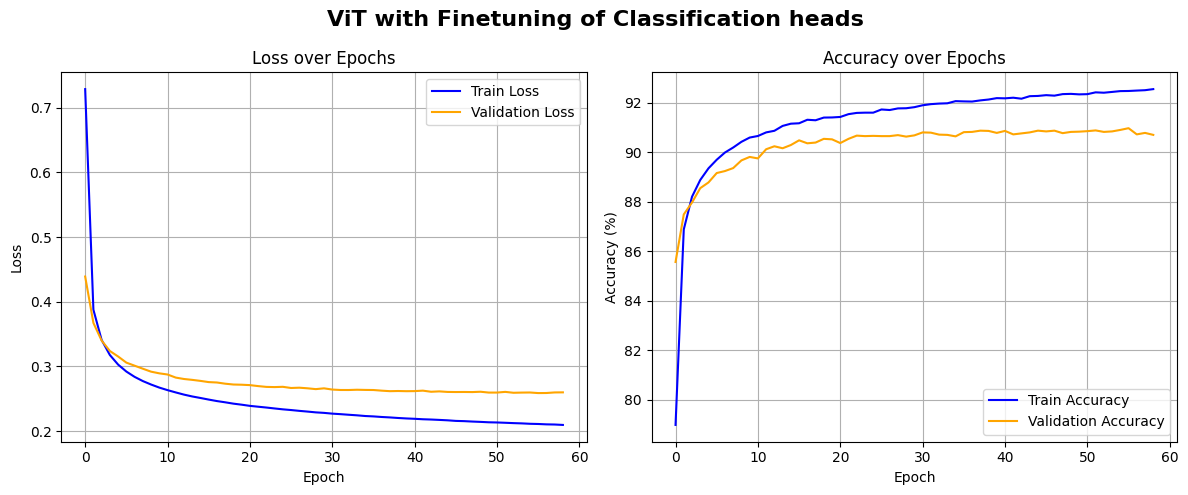

In [23]:
# Set up the figure
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(test_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(test_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()
plt.grid(True)

plt.suptitle("ViT with Finetuning of Classification heads", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("Base.png")  # Save as PNG
plt.show()

In [24]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images).logits
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))



Classification Report:
              precision    recall  f1-score   support

           0     0.8618    0.8540    0.8579      1000
           1     0.9939    0.9820    0.9879      1000
           2     0.8698    0.8750    0.8724      1000
           3     0.8705    0.9010    0.8855      1000
           4     0.8367    0.8710    0.8535      1000
           5     0.9799    0.9740    0.9769      1000
           6     0.7516    0.7050    0.7276      1000
           7     0.9409    0.9720    0.9562      1000
           8     0.9880    0.9870    0.9875      1000
           9     0.9733    0.9490    0.9610      1000

    accuracy                         0.9070     10000
   macro avg     0.9066    0.9070    0.9066     10000
weighted avg     0.9066    0.9070    0.9066     10000



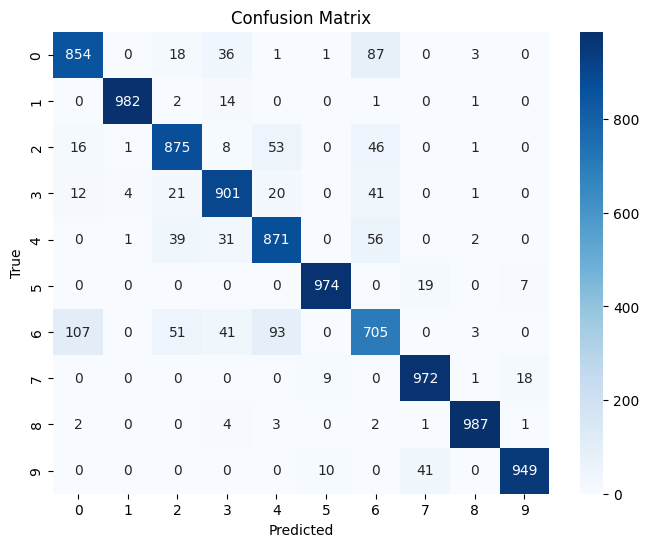

In [25]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()